# **Import**

Needed packages: gym_chess; numpy==1.20; matplotlib; stockfish; tensorflow; tensorflow.keras; optimizers; Adam; models; Sequential; layers; Conv2D; BatchNormalization; MaxPooling2D; Flatten; Dense; Dropout; callbacks; LearningRateScheduler

In [2]:
!pip install gym_chess
!pip install numpy==1.20
import chess
import gym
import gym_chess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import time
from IPython.display import clear_output
import random
!pip install stockfish
from stockfish import Stockfish
Stockfish_path = "C:/Users/Utilizador/Desktop/RL/stockfish_15.1_win_x64_avx2/stockfish-windows-2022-x86-64-avx2.exe"

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import tensorflow as tf

from collections import deque

### **Deep Q- Learning**

The model is model-free, value-based. It's model-free because it learns directly from experiences instead of learning a model of the environment, and it's value-based because it estimates the value of actions rather than directly learning a policy.

The chess environment is fully observable because all information (the positions of all pieces) is available at each step.

### Wrapper

The following wrapper was built to incorporate rewards in the middle of the game and not just the final rewards -1, 0, or 1.

Class Initialization:

The __init__ method initializes the wrapper by inheriting from the gym.Wrapper class and setting up some initial variables.
The num_moves variable keeps track of the number of moves made in the game.
The piece_values dictionary assigns values to different types of chess pieces.
The prev_counts variable stores the counts of each type of piece in the previous state.
The was_king_attacked variable keeps track of whether the king was attacked in the previous move.
Reset Method:

The reset method resets the environment by calling the reset method of the underlying environment and resetting the relevant variables.
Step Method:

The step method overrides the default step method of the wrapped environment.
It takes an action as input and an additional scenario parameter that indicates whether it is "WHITE" or "BLACK" player's move.
The method calls the original step method of the wrapped environment and captures the returned next_state, reward, done, and ignores the original info.
It updates the num_moves counter.
If the game is done (done=True), it adjusts the reward based on the number of moves and the game outcome (win, loss, or draw) for the respective scenario.
It updates the info dictionary with the number of moves and the outcome.
It calculates additional rewards based on the changes in the counts of each type of chess piece from the previous state to the current state.
It checks if the king is attacked in the current move and adjusts the reward accordingly.
It returns the updated next_state, reward, done, and info.
Helper Method _get_piece_counts:

The _get_piece_counts method takes a state as input and counts the number of each type of chess piece present in the state.
It returns a list containing the counts of each type of piece.

The wrapper modifies the game's outcome reward based on whether the game was won, lost, or drawn and the number of moves taken:

Win: If the game is won, the reward is 230 - self.num_moves. This encourages the agent to win the game quickly, as the reward decreases with the number of moves taken.

Loss: If the game is lost, the reward is self.num_moves - 15. This punishes losing but still gives a higher reward for games that last longer, discouraging quick losses.

Draw: If the game ends in a draw, the reward is 100 + self.num_moves. This provides a moderate reward for draws but also gives a bonus for longer games, encouraging the agent to avoid losing.


Material Balance Reward: The wrapper introduces a reward based on changes in the number of each type of piece on the board. If a piece of the opponent is taken (i.e., the count decreases), the agent is rewarded with the value of the taken piece. If a piece of the agent's own side is lost (i.e., the count increases), the agent is punished by subtracting the value of the lost piece from the reward. Piece values are defined as {0: 1, 1: 3, 2: 3, 3: 3, 4: 6, 5: 0}, likely corresponding to pawn, knight, bishop, rook, queen, and king respectively.

King Safety Reward: The wrapper also introduces a reward based on the safety of the king. If the king becomes attacked (checked) on the agent's turn (i.e., is_king_attacked is True when it was previously False), the agent is punished by subtracting 10 from the reward. Conversely, if the king becomes safe on the agent's turn (i.e., is_king_attacked becomes False), the agent is rewarded by adding 10 to the reward.

Note: The step function also returns info, a dictionary containing the number of moves and the game outcome ('win', 'loss', or 'draw').

In [3]:
class ChessEnvWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.num_moves = 0  # Initialize a counter for the number of moves
        self.piece_values = {0: 1, 1: 3, 2: 3, 3: 3, 4: 6, 5: 0}  # Piece values
        self.prev_counts = None
        self.was_king_attacked = False

    def reset(self, **kwargs):
        self.num_moves = 0  # Reset the counter when the environment is reset
        self.prev_counts = None
        self.was_king_attacked = False
        state = super().reset(**kwargs)
        self.prev_counts = self._get_piece_counts(state)
        return state

    def step(self, action, scenario):
        next_state, reward, done, _ = super().step(action)  # Ignore the original info
        self.num_moves += 1
        # Initialize outcome variable
        outcome = None
        info = None

        # Adjust the reward based on the number of moves and whether the game was won, lost, or drawn
        if done:  # only adjust rewards when the game is done
            if scenario == 'WHITE':
                if reward == 1:  # game won
                    reward = 230 - self.num_moves
                    outcome = 'win'
                elif reward == -1:  # game lost
                    reward = self.num_moves - 15
                    outcome = 'loss'
                else:  # game drawn
                    reward = 100 + self.num_moves
                    outcome = 'draw'
            else:
                if reward == -1:  # game won
                    reward = 230 - self.num_moves
                    outcome = 'win'
                elif reward == 1:  # game lost
                    reward = self.num_moves - 15
                    outcome = 'loss'
                else:  # game drawn
                    reward = 100 + self.num_moves
                    outcome = 'draw'
                    
            info = {'num_moves': self.num_moves, 'outcome': outcome}

        if self.prev_counts is not None:
            curr_counts = self._get_piece_counts(next_state)
            for piece in self.piece_values.keys():
                if self.prev_counts[piece] > curr_counts[piece]:
                    reward += self.piece_values[piece]
                elif self.prev_counts[piece] < curr_counts[piece]:
                    reward -= self.piece_values[piece]

            self.prev_counts = curr_counts

        if scenario == 'WHITE':  # white's move
            is_king_attacked = np.any(next_state[:,:,11])
        else:  # black's move
            is_king_attacked = np.any(next_state[:,:,5])

        if is_king_attacked and not self.was_king_attacked:
            reward -= 10
        elif not is_king_attacked and self.was_king_attacked:
            reward += 10

        self.was_king_attacked = is_king_attacked

        return next_state, reward, done, info

    def _get_piece_counts(self, state):
        """Count the number of each type of piece in the given state"""
        return [np.sum(state[:, :, i]) for i in range(6)]


**Global Parameters**

Global Parameters that were used multiple times throughout the code, in tuning, these parameters might need adjusting.

In [4]:
# Define optimizer at the global scope
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
batch_size=32

The function build_model(states, actions) constructs and compiles a convolutional neural network (CNN) using Keras, a high-level neural networks API running on top of TensorFlow.

Learning Rate Decay: The model uses an Adam optimizer with a learning rate that decays exponentially after a certain number of steps. This means the learning rate will decrease over time, allowing the model to make large updates early in training and smaller updates later on. This can help the model converge more effectively.

Input and Output: The model takes as input the state of the game (presumably a matrix representation of the chess board) and outputs a vector representing the Q-values of possible actions.

The neural network might also need tuning, both in structure and in type of Neural Network - alphago uses ResNet.

In [5]:
def build_model(states, actions, initial_learning_rate = 0.1, decay_steps=10, decay_rate=0.9):
    model = Sequential()

    model.add(Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=states))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=3, strides=1, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=2))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(actions, activation='linear'))

    lr_schedule = ExponentialDecay(
        initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True  # If True, the learning rate decays at discrete intervals
    )

    # Define optimizer with learning rate schedule
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(loss='mse', optimizer=optimizer)

    return model


This ReplayBuffer class is an implementation of an important concept in reinforcement learning known as experience replay. In reinforcement learning, an agent learns by interacting with its environment and receiving rewards or penalties. Over time, the agent will encounter different situations (states) and perform various actions that lead to rewards.

Experience replay allows the agent to learn from this past experience. The ReplayBuffer stores these experiences (specifically state, action, reward, next state, and done tuples) in a data structure known as a deque, which is a type of list where elements can be added or removed from both ends efficiently.

push: Adds an experience to the buffer. If the buffer is full (i.e., it has reached its maximum capacity), the oldest experience is automatically removed.

sample: Randomly samples a mini-batch of experiences from the buffer. These experiences are used to update the agent's knowledge.

__len__: Returns the current number of experiences in the buffer.

As for the capacity of the buffer (50000 in this case), it's largely a hyperparameter that can be tuned. However, it's generally beneficial to have a large enough buffer to contain a wide range of experiences but not so large that it is using excessive memory. The specific value of 50000 means that the agent will keep the most recent 50000 experiences.



In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.array(state), np.array(action), np.array(reward, dtype=np.float32), np.array(next_state), np.array(done, dtype=np.uint8)

    def __len__(self):
        return len(self.buffer)

buffer = ReplayBuffer(50000)
loss_values = []


This function compute_loss calculates the loss for a batch of experiences.

Here are the steps it follows:

If the number of experiences in the replay buffer is less than the batch size, it returns None. This is because it's not possible to sample a batch of experiences in this case.

It then samples a batch of experiences from the replay buffer using the sample method.

For each experience in the batch, it computes the Q-value for the action taken in the initial state (current_Q). This is done by using the model to predict the Q-values for all actions in the state and then selecting the Q-value for the action that was actually taken.

It then computes the maximum Q-value for the next state (next_Q). This is done by using the model to predict the Q-values for all actions in the next state and then taking the maximum.

It computes the target Q-value (target_Q) for the action taken in the initial state. This is done using the formula for Q-learning, of  Bellman equations: reward + (1 - done) * gamma * next_Q. Here, gamma is the discount factor which determines the present value of future rewards, set to 0.99. If done is 1, meaning the episode ended after this action, then the future value is 0.

It computes the loss as the mean squared error between the current Q-value and the target Q-value. This is the quantity that we will try to minimize during training.

It appends the loss to the loss_values list, which seems to be used for monitoring the loss during training.

The function returns the computed loss.

In [7]:
def compute_loss(batch_size, discount_factor):
    if len(buffer) < batch_size:
        return None

    state, action, reward, next_state, done = buffer.sample(batch_size)
    state = np.float32(state / 255.0)
    next_state = np.float32(next_state / 255.0)
    reward = reward[:, None]
    done = done[:, None]

    current_Q = model.predict(state)[np.arange(batch_size), action]
    next_Q = model.predict(next_state).max(axis=1)
    next_Q = next_Q.reshape(-1, 1) # Reshape next_Q to match the shape of done and reward

    target_Q = (reward + (1 - done) * discount_factor * next_Q).flatten()

    loss = tf.keras.losses.MSE(current_Q, target_Q)

    # Append the loss to the loss_values list
    loss_values.append(loss.numpy())  # Use .numpy() to convert the tensor to a numpy array

    return loss

This function updates the model using the gradients calculated from the loss.

This function utilizes the compute_loss function to calculate the loss and then updates the model's parameters. It essentially wraps the compute_loss function and model updating into one function.

In [8]:
@tf.function
def update(batch_size):
    with tf.GradientTape() as tape:
        loss = compute_loss(batch_size, discount_factor)
    if loss is not None:
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

The WHITE_PLAYER_POLICY and BLACK_PLAYER_POLICY functions define the behavior of the white and black players, respectively, in a chess game. They determine how the players select their moves based on the current state and the learned Q-values from the Q-learning model.

Both functions convert the legal moves available in the environment into action indices and initialize a variable to track the maximum Q-value. They then make a decision based on an exploration-exploitation trade-off - depending on if the random number generated between 0 and 1 is bigger or smallar than the current epsilon.

During exploration, a random legal action is chosen with a probability determined by the exploration rate (epsilon). This allows the players to explore different actions and gather more information about the environment.

During exploitation, the functions use the Q-learning model to predict the Q-values for the given state. The action with the highest Q-value is selected and assigned as the chosen action.

In the end, the functions return the chosen action and the maximum Q-value, which can be used for analysis or monitoring the learning process.

In [9]:
def WHITE_PLAYER_POLICY(env, state, model, epsilon):
    legal_actions = list(map(env.encode, env.legal_moves))  # Convert legal moves to action indices
    max_q_value = 0  # Initialize max_q_value

    if np.random.rand() <= epsilon:
        action = np.random.choice(legal_actions)  # Explore legal action space
    else:
        # Reshape the state to match the expected input shape
        reshaped_state = np.expand_dims(state, axis=0)
        q_values = model.predict(reshaped_state)  # Exploit learned values
        max_q_value = np.max(q_values[0]) 
        action = np.argmax(q_values[0])
        if action not in legal_actions:
            action = np.random.choice(legal_actions)  # Fallback to random legal action if chosen action is illegal
    
    return action, max_q_value


def BLACK_PLAYER_POLICY(env, state, model, epsilon):
    legal_actions = list(map(env.encode, env.legal_moves))  # Convert legal moves to action indices
    max_q_value = 0  # Initialize max_q_value

    if np.random.rand() <= epsilon:
        action = np.random.choice(legal_actions)  # Explore legal action space
    else:      
        # Reshape the state to match the expected input shape
        reshaped_state = np.expand_dims(state, axis=0)
        q_values = model.predict(reshaped_state)  # Exploit learned values
        max_q_value = np.max(q_values[0]) 
        action = np.argmax(q_values[0])
        if action not in legal_actions:
            action = np.random.choice(legal_actions)  # Fallback to random legal action if chosen action is illegal
    
    return action, max_q_value



The functions generate_WHITE_scenario and generate_BLACK_scenario are designed to simulate a complete game of chess, with the agent playing as either the white or black player against Stockfish, a popular open-source chess engine.

In both functions, Stockfish is set to a certain ELO rating to determine its playing strength (1900 for the white scenario, and 1100 for the black scenario).

Here's a step-by-step breakdown of these functions:

Environment Setup: A new chess environment is created and the game is reset to its starting state.

Game Loop: The game continues until a terminal state is reached (game is done). During each step, the current player makes a move based on its policy.

Agent's Turn: On the agent's turn (white player in generate_WHITE_scenario and black player in generate_BLACK_scenario), the agent selects an action based on the provided AGENT_POLICY, which is an epsilon-greedy policy as discussed previously. The chosen action is then applied to the environment, the state is updated, and the details of this transition are stored in the replay buffer. The model is also updated if the buffer size exceeds the batch size.

Stockfish's Turn: On Stockfish's turn, it chooses the best move based on its internal algorithms. The move is then applied to the environment, the state is updated, and the details of this transition are also stored in the replay buffer. Similarly, the model is updated if the buffer size exceeds the batch size.

Centipawn Score: After each move, the centipawn score is retrieved from Stockfish. This score is a measure of the current board state from Stockfish's perspective. It is added to a list of centipawn scores for the game. Note that for generate_BLACK_scenario, the centipawn score is negated as it's from black's perspective.

Outcome: After the game is done, the function checks if there's an outcome. If there is, it's stored.

Closing the Environment: After the game is done, the chess environment is closed.

Return Values: The functions return the final reward, the number of moves, the list of centipawn scores throughout the game, the outcome, the Q-values and epsilon values of the agent's states.

These functions are essentially the same, with the only differences being the player the agent represents (white or black) and the ELO rating of Stockfish.

In [10]:
def generate_WHITE_scenario(Stockfish_path, AGENT_POLICY, model, scenario,epsilon, discount_factor):
    env = ChessEnvWrapper(gym.make('ChessAlphaZero-v0'))
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(1900)

    state = env.reset()
    done = False
    counter = 0 
    outcome = None
    centipawn_scores = []  # List to store centipawn scores

    while not done:
        if counter % 2 == 0:  # If the step number is pair, this means that it is the WHITE player's turn
            action, max_q_value = AGENT_POLICY(env, state, model, epsilon)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action, 'WHITE') # Removed scenario
            buffer.push(state, action, reward, next_state, done)
            # Update the model
            if len(buffer) >= batch_size:
                loss = compute_loss(batch_size, discount_factor)
            state = next_state

            state_values_white=(max_q_value)
            epsilons_white=(epsilon)
        else:  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action, 'WHITE')
            buffer.push(state, action, reward, next_state, done)
            # Update the model
            if len(buffer) >= batch_size:
                loss = compute_loss(batch_size, discount_factor)
            state = next_state
        
        centipawn_score = stockfish.get_evaluation()['value']  # Get the centipawn score
        centipawn_scores.append(centipawn_score)  # Add the centipawn score to the list

        state = next_state
        counter += 1
    if info['outcome'] is not None:
        outcome = info['outcome']


    num_moves = np.ceil(counter / 2)

    env.close()

    return reward, num_moves, centipawn_scores, outcome, state_values_white, epsilons_white  # Return the list of centipawn scores

def generate_BLACK_scenario(Stockfish_path, AGENT_POLICY, model, scenario, epsilon, discount_factor):
    env = ChessEnvWrapper(gym.make('ChessAlphaZero-v0'))
    stockfish = Stockfish(Stockfish_path)
    stockfish.set_elo_rating(1100)
    outcome = None
    state = env.reset()
    done = False
    counter = 0 
    
    centipawn_scores = []  # List to store centipawn scores

    while not done:
        if counter % 2 == 0:  # If the step number is pair, this means that it is the WHITE player's turn
            decoded_action = stockfish.get_best_move()
            action = env.encode(chess.Move.from_uci(decoded_action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action, 'BLACK')

            buffer.push(state, action, reward, next_state, done)
            # Update the model
            if len(buffer) >= batch_size:
                loss = compute_loss(batch_size, discount_factor)
            state = next_state
        else:  # If the step number is not pair, aka odd, this means that it is the BLACK player's turn
            action, max_q_value = AGENT_POLICY(env, state, model, epsilon)
            decoded_action = str(env.decode(action))
            stockfish.make_moves_from_current_position([decoded_action])
            next_state, reward, done, info = env.step(action, 'BLACK') # Removed scenario
            buffer.push(state, action, reward, next_state, done)
            # Update the model
            if len(buffer) >= batch_size:
                loss = compute_loss(batch_size, discount_factor)
            state = next_state
            
            state_values_black=(max_q_value)
            epsilons_black=(epsilon)

        centipawn_score = -stockfish.get_evaluation()['value']  # Get the centipawn score
        centipawn_scores.append(centipawn_score)  # Add the centipawn score to the list

        state = next_state
        counter += 1
    if info['outcome'] is not None:
        outcome = info['outcome']


    num_moves = np.ceil(counter / 2)

    env.close()

    return reward, num_moves, centipawn_scores, outcome, state_values_black, epsilons_black  # Return the list of centipawn scores



This function evaluates the performance of the agent by having it play several games against Stockfish and recording the outcomes. It also plots the agent's performance, loss, and centipawn scores over time.

The function AGENT_EVALUATION() is a simulation and evaluation function for a reinforcement learning agent playing chess. It uses the 'Stockfish' chess engine and plays a number of games, in both white and black positions, following a policy defined by the AGENT_POLICY. The model being used is passed as an argument. The number of games played for evaluation is defined by n_evaluations.

Here's an overview of what the function does:

In each evaluation, the agent plays two games, one as white and the other as black. The games are generated using the generate_WHITE_scenario and generate_BLACK_scenario functions respectively. The agent's performance, the number of moves, centipawn scores, the outcome of the game, and the state values are recorded for each game.

After the games are played, a DataFrame is created to store the results. The agent's color, the outcome of the game, and the number of moves are recorded.

Then it plots the distribution of outcomes (wins, losses, and draws) for both white and black using a stacked bar plot.

Then, it computes and prints the number of games that ended in a draw, win, or loss.

After that, it plots the agent's performance over time. The performance is represented by the reward accumulated during each game. It then computes a moving average of the performance and plots it to smooth out the trends.

It also plots the number of moves for each game over time and their moving averages.

Then, it plots the state values and epsilon values over the steps and their moving averages for both white and black.

It also plots the loss values over the training step and their moving averages.

Lastly, it plots the centipawn scores (an evaluation metric used in chess to measure the advantage of a position) over the course of the games and their moving averages.

Finally, it returns the DataFrame df that stores the results of all games played.

The code at the end is creating an environment for the chess game using 'ChessAlphaZero-v0', building a model, and then running the AGENT_EVALUATION function.

In [11]:

def AGENT_EVALUATION(Stockfish_path,AGENT_POLICY, model, n_evaluations=100, epsilon=1, epsilon_min=0.01, epsilon_decay=0.985, discount_factor = 0.99, avg_window_small=100, avg_window_big=1250):
    results_list = []
    performance = []
    performance_white=[]
    centipawn_scores_white=[]
    performance_black=[]
    centipawn_scores_black=[]
    state_values_white_list = []
    epsilons_white_list = []

    state_values_black_list = []
    epsilons_black_list = []
    
    for evaluation_number in tqdm(range(n_evaluations)):
        generate_episode = generate_WHITE_scenario

        reward, num_moves, centipawn_scores, outcome, state_values_white, epsilons_white = generate_episode(Stockfish_path, AGENT_POLICY, model, 'WHITE', epsilon, discount_factor)
        epsilon= epsilons_white
        performance_white.append(reward)
        centipawn_scores_white.append(centipawn_scores)
        performance.append(reward)
        state_values_white_list.append(state_values_white)
        epsilons_white_list.append(epsilons_white)
        results_list.append(["WHITE", outcome, num_moves])


        generate_episode = generate_BLACK_scenario

        reward, num_moves, centipawn_scores, outcome, state_values_black, epsilons_black = generate_episode(Stockfish_path, AGENT_POLICY, model, 'BLACK', epsilon, discount_factor)
        epsilon= epsilons_black
        performance_black.append(reward)
        centipawn_scores_black.append(centipawn_scores)
        state_values_black_list.append(state_values_black)
        epsilons_black_list.append(epsilons_black)
        performance.append(reward)

        results_list.append(["BLACK", outcome, num_moves])
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    df = pd.DataFrame(
        results_list, columns=["AGENT COLOR", "OUTCOME", "N STEPS"]
    ).astype({"N STEPS": int}, errors="ignore")

    plt.style.use("fivethirtyeight")

    results_group = (
        df.groupby(["AGENT COLOR", "OUTCOME"])
        .count()
        .rename(columns={"N STEPS": "GAMES"})
    )

    n_games = results_group.sum()[0]

    results_group = (100 * results_group / n_games).round(2)

    viz_df = (
        results_group.reset_index()
        .pivot_table(index="AGENT COLOR", columns="OUTCOME", values="GAMES")
        .fillna(0)
    )

    viz_df.plot(kind="barh", stacked=True)

    plt.xlabel("Percentage")
    plt.title(f"EVALUATION RESULTS FOR {n_games} GAMES")

    plt.show()

    # Compute the number of games that ended in a draw, win, or loss
    num_draws = df[df["OUTCOME"] == "draw"].shape[0]
    num_wins = df[df["OUTCOME"] == "win"].shape[0]
    num_losses = df[df["OUTCOME"] == "loss"].shape[0]

    print(f"Number of games that ended in a draw: {num_draws}")
    print(f"Number of games won: {num_wins}")
    print(f"Number of games lost: {num_losses}")

    def moving_average(a, n=avg_window_small) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n


    # Plot the performance over time for both colors
    plt.figure(figsize=(25, 10))  # Change the size of the figure
    plt.plot(performance_white, label='WHITE')
    plt.plot(performance_black, label='BLACK')
    plt.xlabel('Epoch')
    plt.ylabel('Performance')
    plt.title('Agent Performance Over Time')
    plt.legend()
    plt.show()

    # Compute moving average
    performance_white_moving_avg = moving_average(np.array(performance_white))
    performance_black_moving_avg = moving_average(np.array(performance_black))

    # Plot the moving average of the performance over 25 episodes for both colors
    plt.figure(figsize=(25, 10))  # Change the size of the figure
    plt.plot(performance_white_moving_avg, label='WHITE')
    plt.plot(performance_black_moving_avg, label='BLACK')
    plt.xlabel('Epoch')
    plt.ylabel(f'Performance (Moving Average over {avg_window_small} episodes)')
    plt.title('Agent Performance Over Time (Moving Average over 25 episodes)')
    plt.legend()
    plt.show()

    # Extract the number of moves for each game
    num_moves_white = df[df["AGENT COLOR"] == "WHITE"]["N STEPS"].tolist()
    num_moves_black = df[df["AGENT COLOR"] == "BLACK"]["N STEPS"].tolist()

    # Plot the number of moves per game for both colors
    plt.figure(figsize=(25, 10))  # Change the size of the figure
    plt.plot(num_moves_white, label='WHITE')
    plt.plot(num_moves_black, label='BLACK')
    plt.xlabel('Game Number')
    plt.ylabel('Number of Moves')
    plt.title('Number of Moves Per Game Over Time')
    plt.legend()
    plt.show()

    # Compute the moving average of the number of moves
    num_moves_white_moving_avg = moving_average(np.array(num_moves_white))
    num_moves_black_moving_avg = moving_average(np.array(num_moves_black))

    # Plot the moving average of the number of moves per game for both colors
    plt.figure(figsize=(25, 10))  # Change the size of the figure
    plt.plot(num_moves_white_moving_avg, label='WHITE')
    plt.plot(num_moves_black_moving_avg, label='BLACK')
    plt.xlabel('Game Number')
    plt.ylabel(f'Number of Moves (Moving Average over {avg_window_small} games)')
    plt.title('Number of Moves Per Game Over Time (Moving Average over 40 games)')
    plt.legend()
    plt.show()
    
    # For state values
    plt.figure(figsize=(25, 10))

    # Plotting for white
    plt.subplot(1, 2, 1)
    plt.plot(state_values_white_list)
    plt.title("State Values for White")
    plt.xlabel('Steps')
    plt.ylabel('State Values')

    # Plotting for black
    plt.subplot(1, 2, 2)
    plt.plot(state_values_black_list, 'r')
    plt.title("State Values for Black")
    plt.xlabel('Steps')
    plt.ylabel('State Values')

    plt.tight_layout()
    plt.show()

    # For state values
    plt.figure(figsize=(25, 10))

    # Plotting for white
    plt.subplot(1, 2, 1)
    plt.plot(moving_average(state_values_white_list))
    plt.title("Moving Average State Values for White")
    plt.xlabel('Steps')
    plt.ylabel('State Values')

    # Plotting for black
    plt.subplot(1, 2, 2)
    plt.plot(moving_average(state_values_black_list), 'r')
    plt.title("Moving Average State Values for Black")
    plt.xlabel('Steps')
    plt.ylabel('State Values')

    plt.tight_layout()
    plt.show()

    # For epsilons
    plt.figure(figsize=(25, 10))

    # Plotting for white
    plt.subplot(1, 2, 1)
    plt.plot(epsilons_white_list)
    plt.title("Epsilons for White")
    plt.xlabel('Steps')
    plt.ylabel('Epsilon')

    # Plotting for black
    plt.subplot(1, 2, 2)
    plt.plot(epsilons_black_list, 'r')
    plt.title("Epsilons for Black")
    plt.xlabel('Steps')
    plt.ylabel('Epsilon')

    plt.tight_layout()
    plt.show()

    def moving_average(a, n=avg_window_big) :
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n


    plt.figure(figsize=(25, 10))
    plt.plot(loss_values)
    plt.title("Loss over Time")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.show()

    # Compute moving average
    loss_values_moving_avg = moving_average(np.array(loss_values))

    plt.figure(figsize=(25, 10))
    plt.plot(loss_values_moving_avg)
    plt.title(f"Loss over Time (Moving Average over {avg_window_big} episodes)")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.show()


    centipawn_scores_global_white_flat = [item for sublist in centipawn_scores_white for item in sublist]
    centipawn_scores_global_black_flat = [item for sublist in centipawn_scores_black for item in sublist]

    # Plot the centipawn scores for this game
    plt.figure(figsize=(25, 10))  # Change the size of the figure
    plt.plot(centipawn_scores_global_white_flat, label='WHITE')
    plt.plot(centipawn_scores_global_black_flat, label='BLACK')
    plt.xlabel('Move number')
    plt.ylabel('Centipawn score')
    plt.title('Centipawn score over the course of the game')
    plt.show()


    #  `centipawn_scores` is the list of scores
    centipawn_scores_white_moving_avg = moving_average(np.array(centipawn_scores_global_white_flat))
    centipawn_scores_black_moving_avg = moving_average(np.array(centipawn_scores_global_black_flat))
    # Plot the moving average of the centipawn scores over 20 episodes
    plt.figure(figsize=(25, 10))  # Change the size of the figure
    plt.plot(centipawn_scores_white_moving_avg, label='WHITE')
    plt.plot(centipawn_scores_black_moving_avg, label='BLACK')
    plt.xlabel('Episode')
    plt.ylabel(f'Centipawn Score (Moving Average over {avg_window_big} episodes)')
    plt.title(f'Centipawn Score Over Time (Moving Average over {avg_window_big} episodes)')
    plt.legend()
    plt.show()

    return df

The parameters used to run, that do not have a global scope like the ones mentioned in the beginning are:

In the build_model function initial_learning_rate, decay_steps=10, and decay_rate=0.9, the names are self explanatory and they are respnsible for the decay of the learning rate.
When tuning this, the code right after this allows for the programmer to select parameters that go according to their user wishes.

In the AGENT_EVALUATION function:
    epsilon, epsilon_min, epsilon_decay - similar to before, are responsible for the decay of epsilon and there is also a piece of code to tune it next to this.
    discount_factor - select the factor between 0 and 1
    avg_window_small, avg_window_big - when ploting the final results the number of episodes to perform moving average over is different, depending on the number of games run and the intended plots. "avg_window_small" is used when there is only one value per game, such as number of moves; avg_window_big is meant for plots that have multiple values per game, such as centipawn scores.

In [15]:
initial_learning_rate = 0.1
decay_steps = 10
decay_rate = 0.9
step=1000
final_lr = initial_learning_rate * decay_rate ** (step / decay_steps)
print(final_lr)

2.6561398887587545e-06


In [12]:
epsilon = 1
epsilon_min = 0.01
epsilon_decay = 0.985
number_of_episodes = 0  # Initialize at 0

while epsilon > epsilon_min:
    epsilon *= epsilon_decay
    number_of_episodes += 1

print(f"It took {number_of_episodes} episodes for epsilon to reach the minimum.")

It took 305 episodes for epsilon to reach the minimum.


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 1s 769ms/step


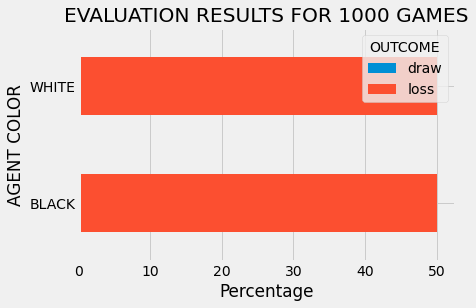

Number of games that ended in a draw: 1
Number of games won: 0
Number of games lost: 999


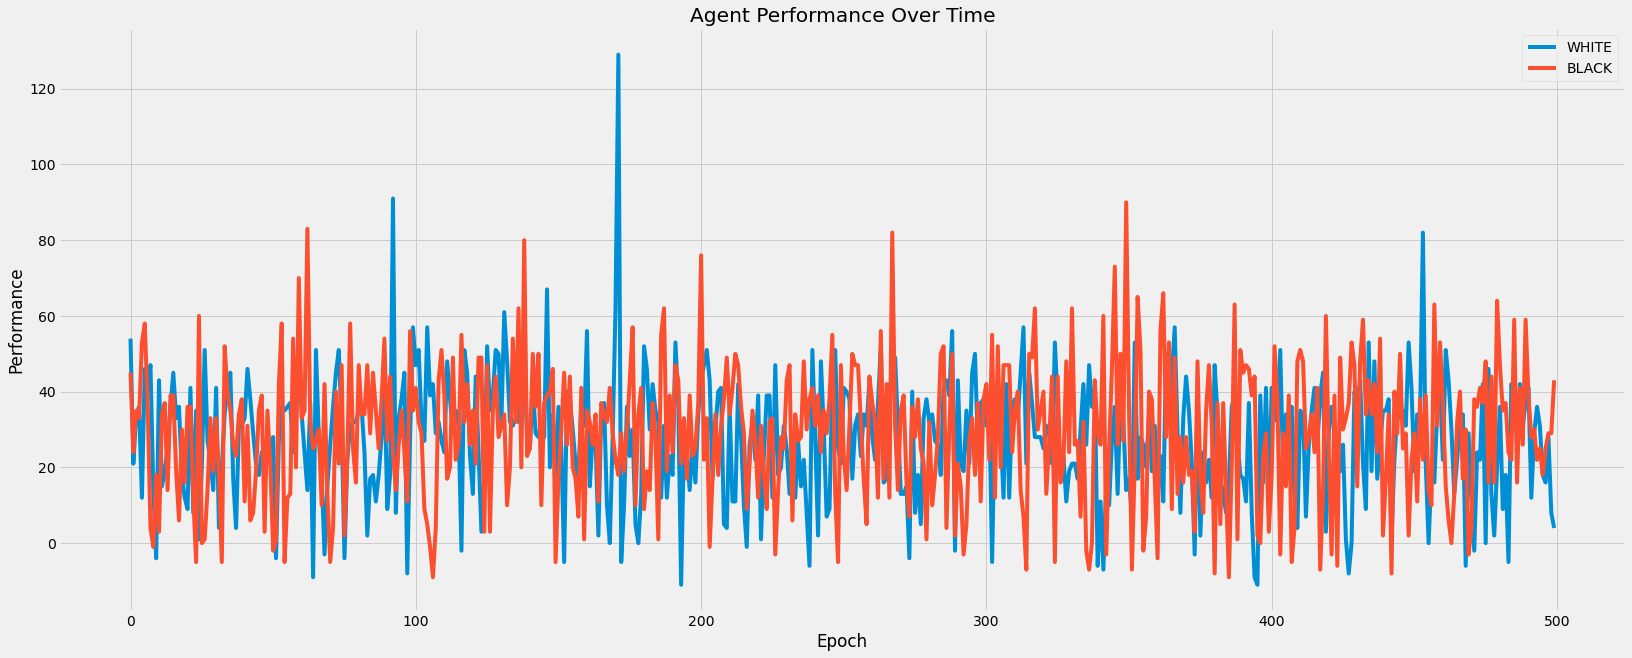

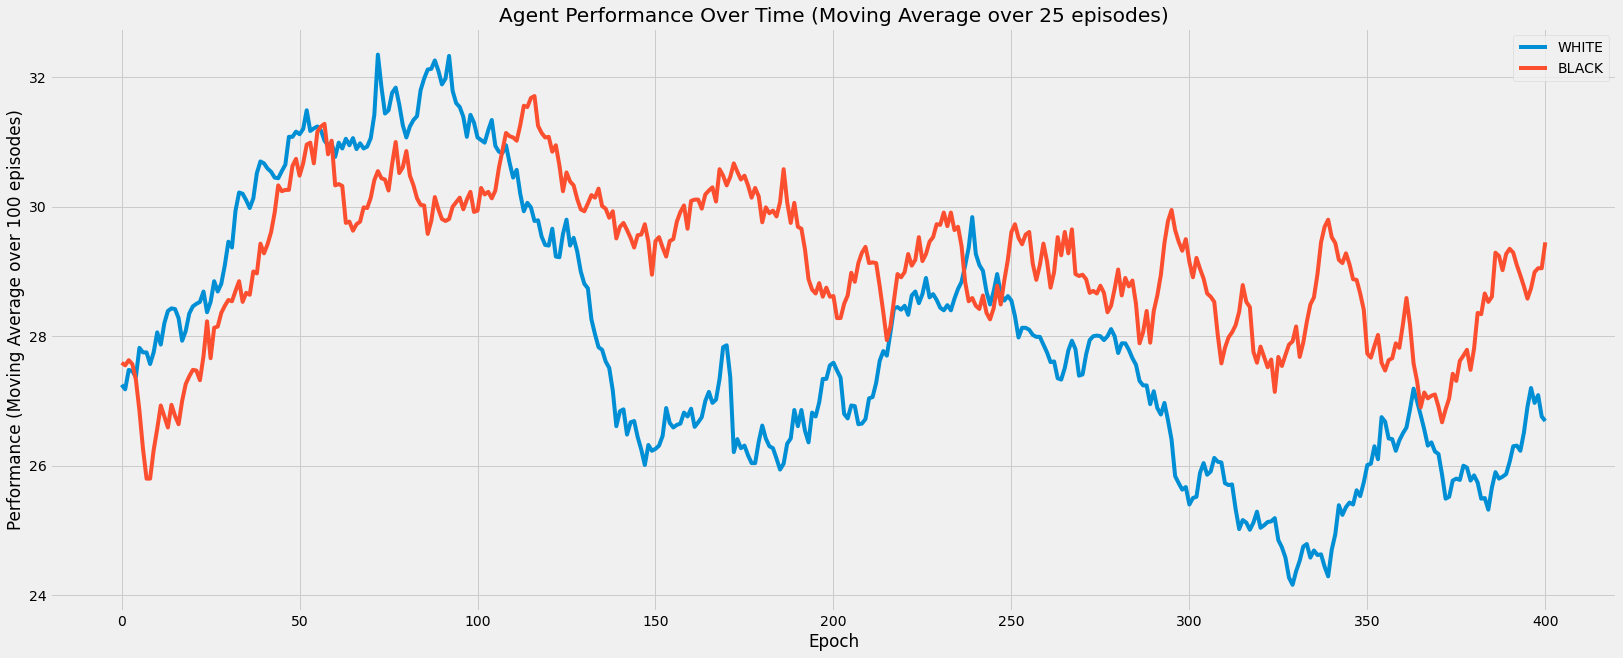

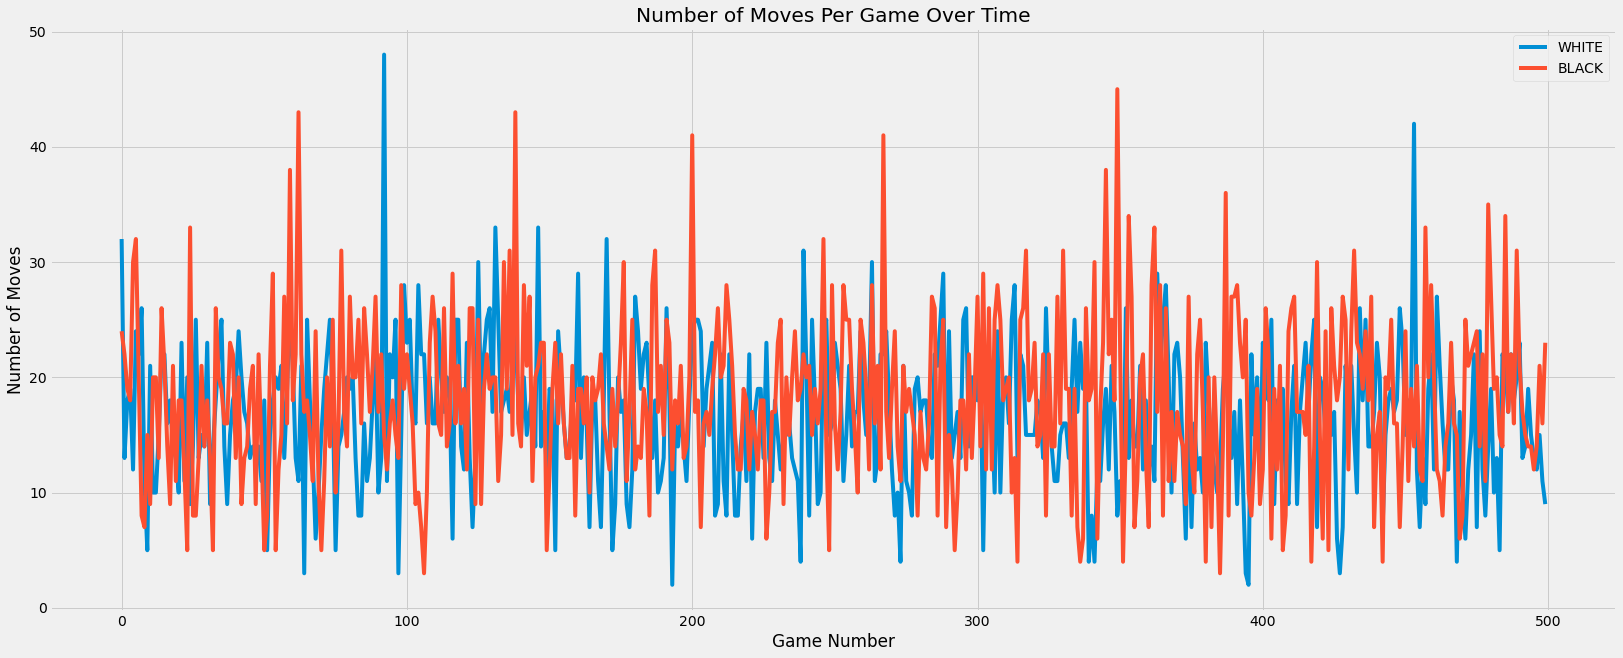

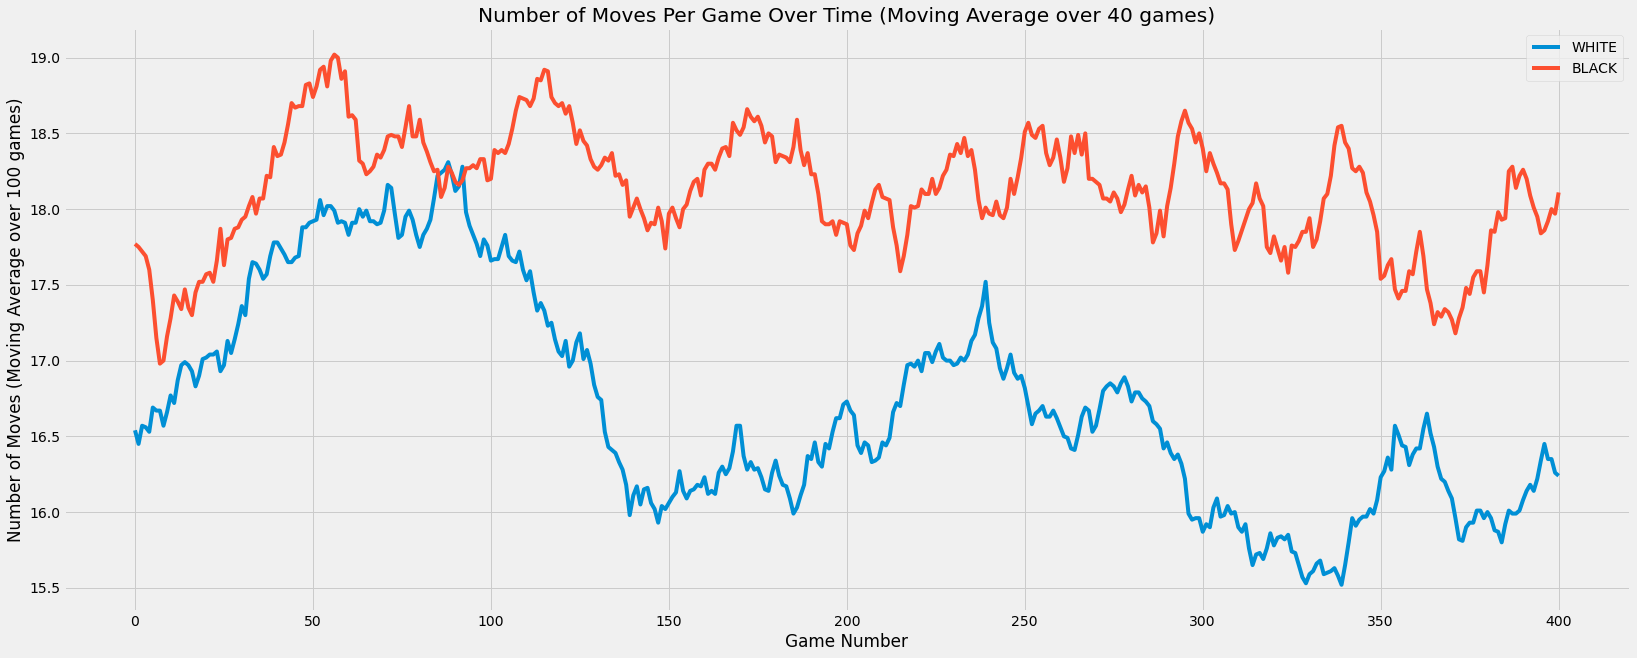

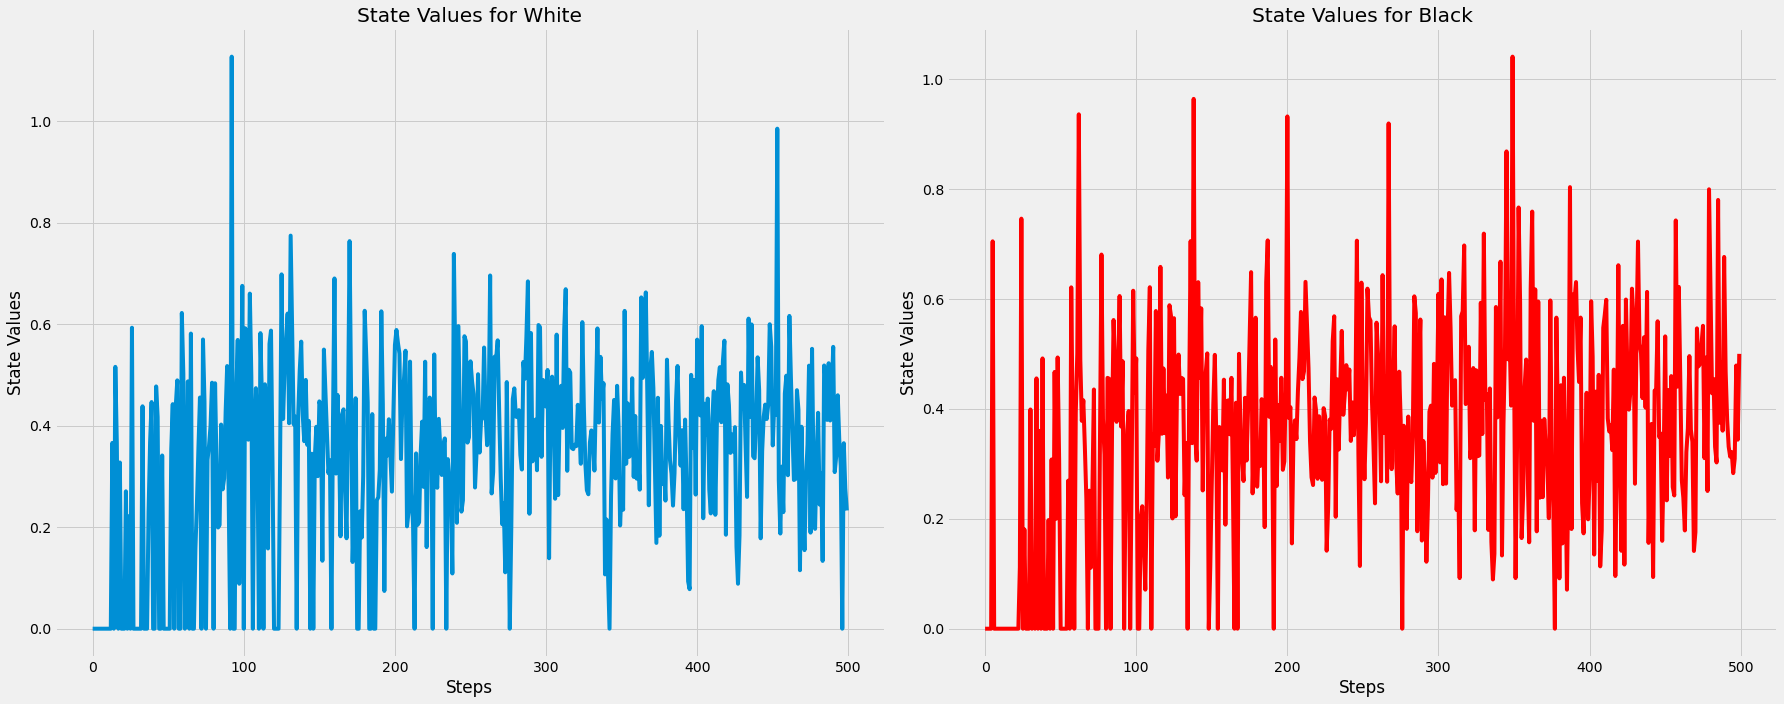

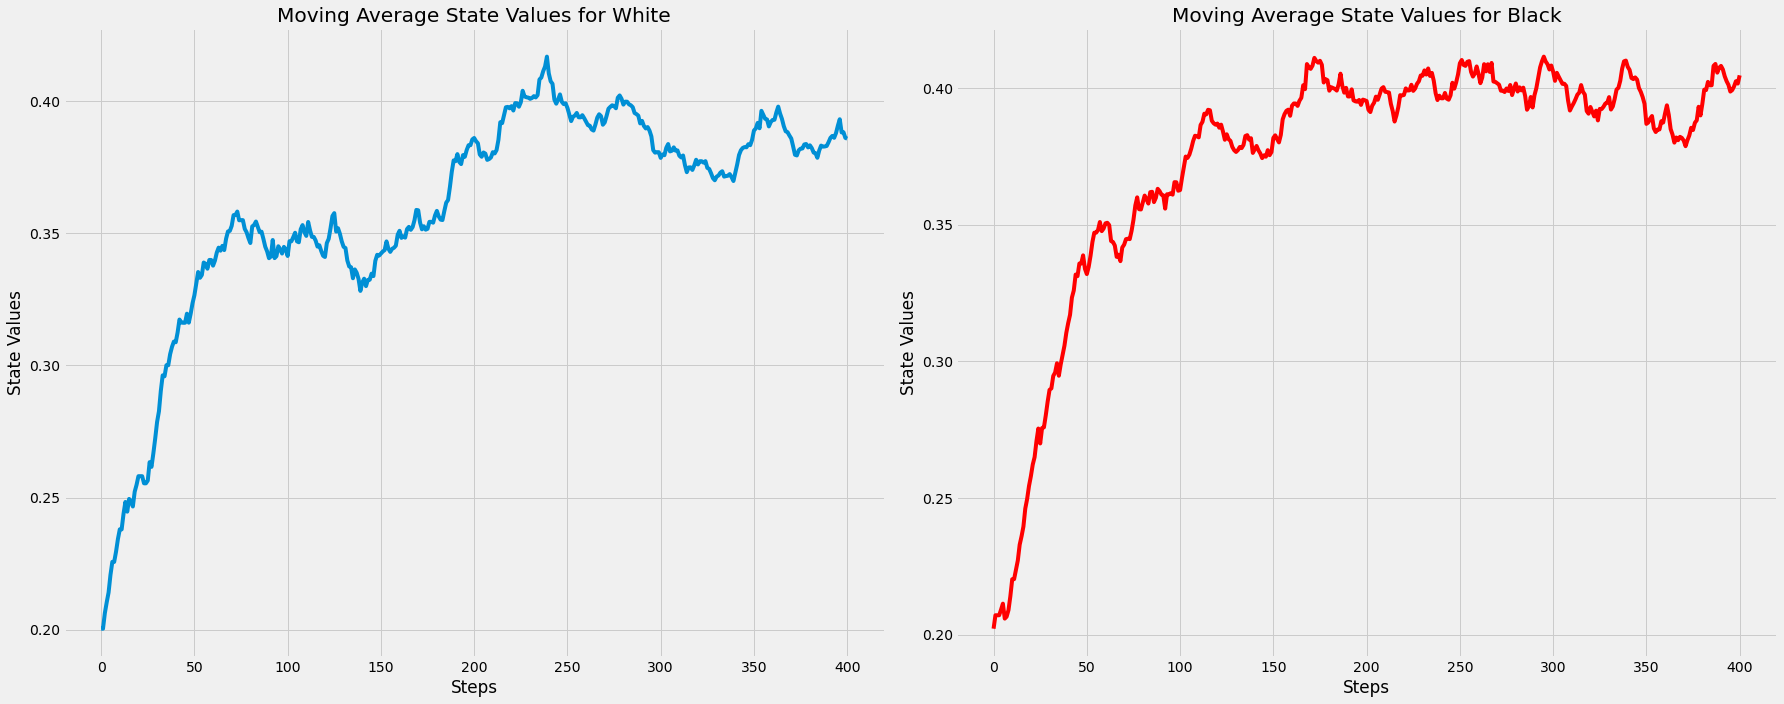

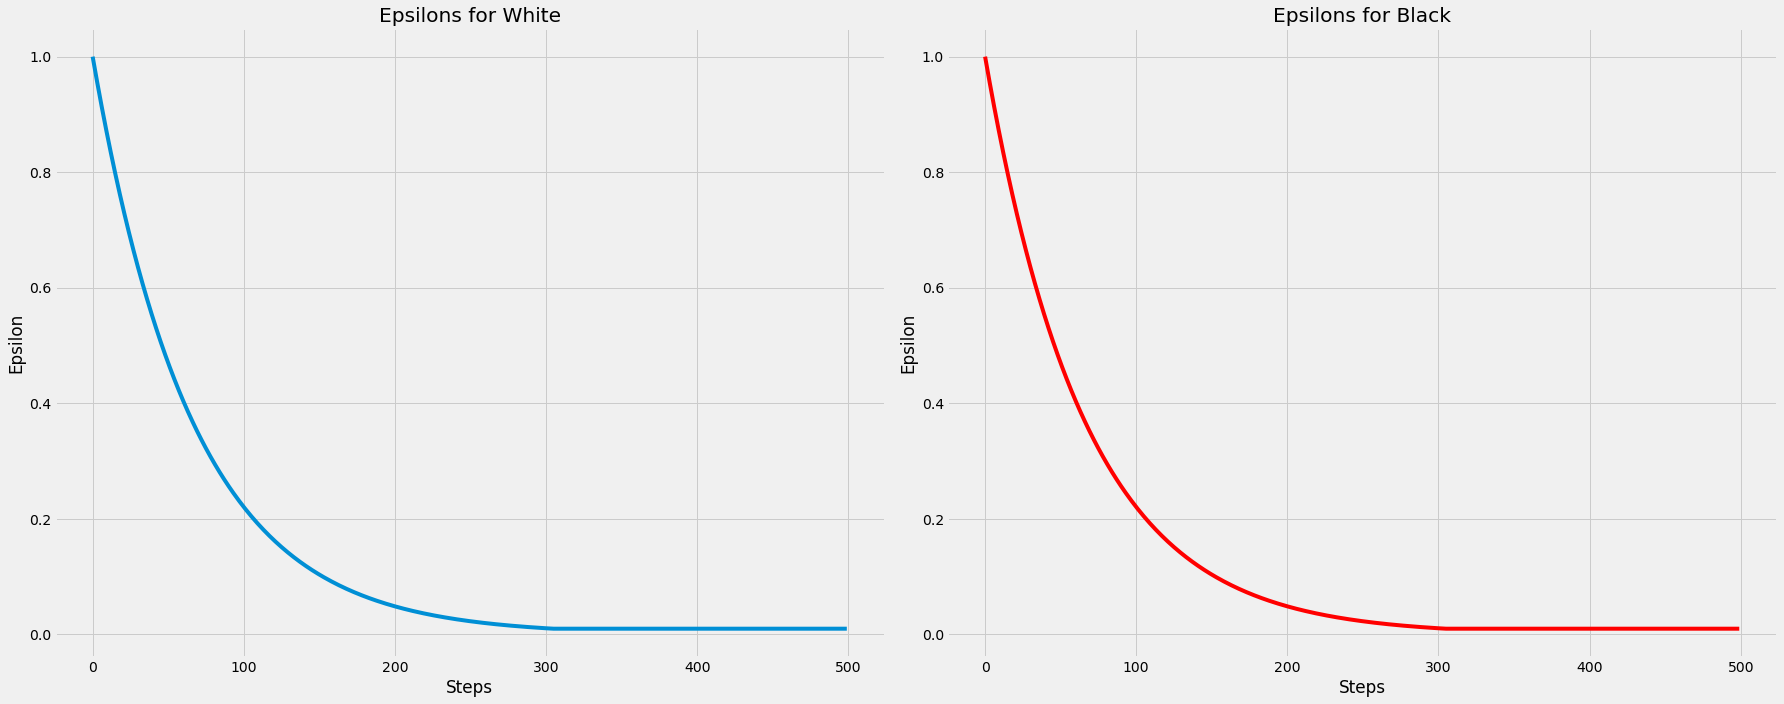

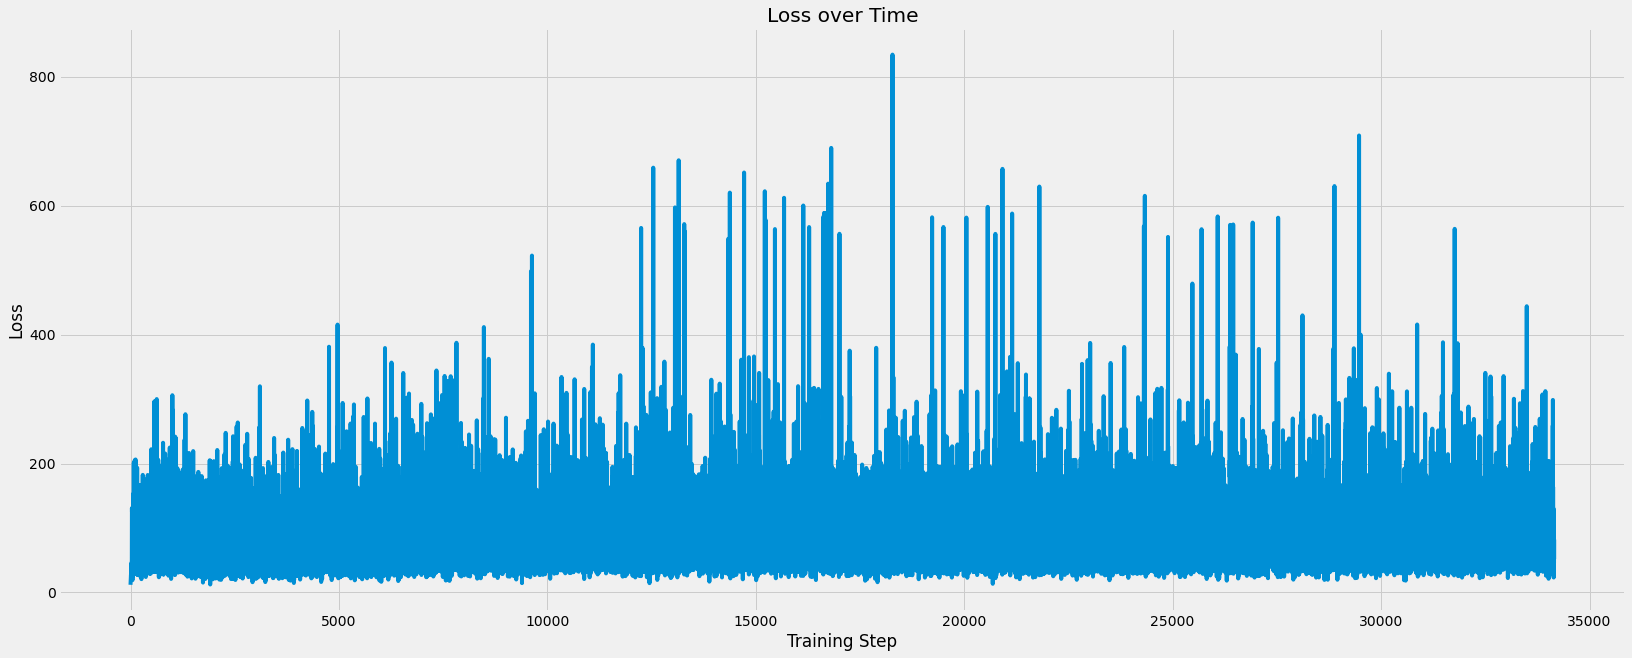

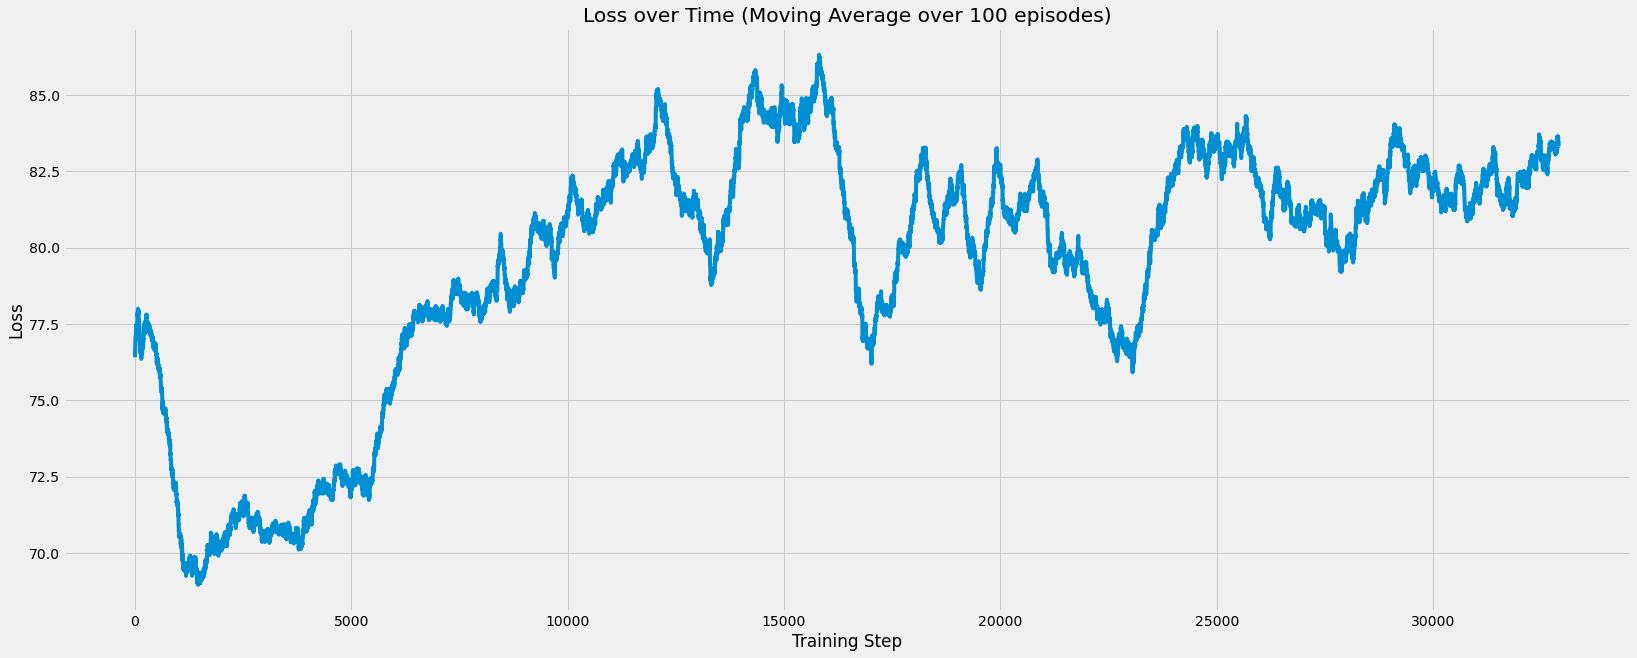

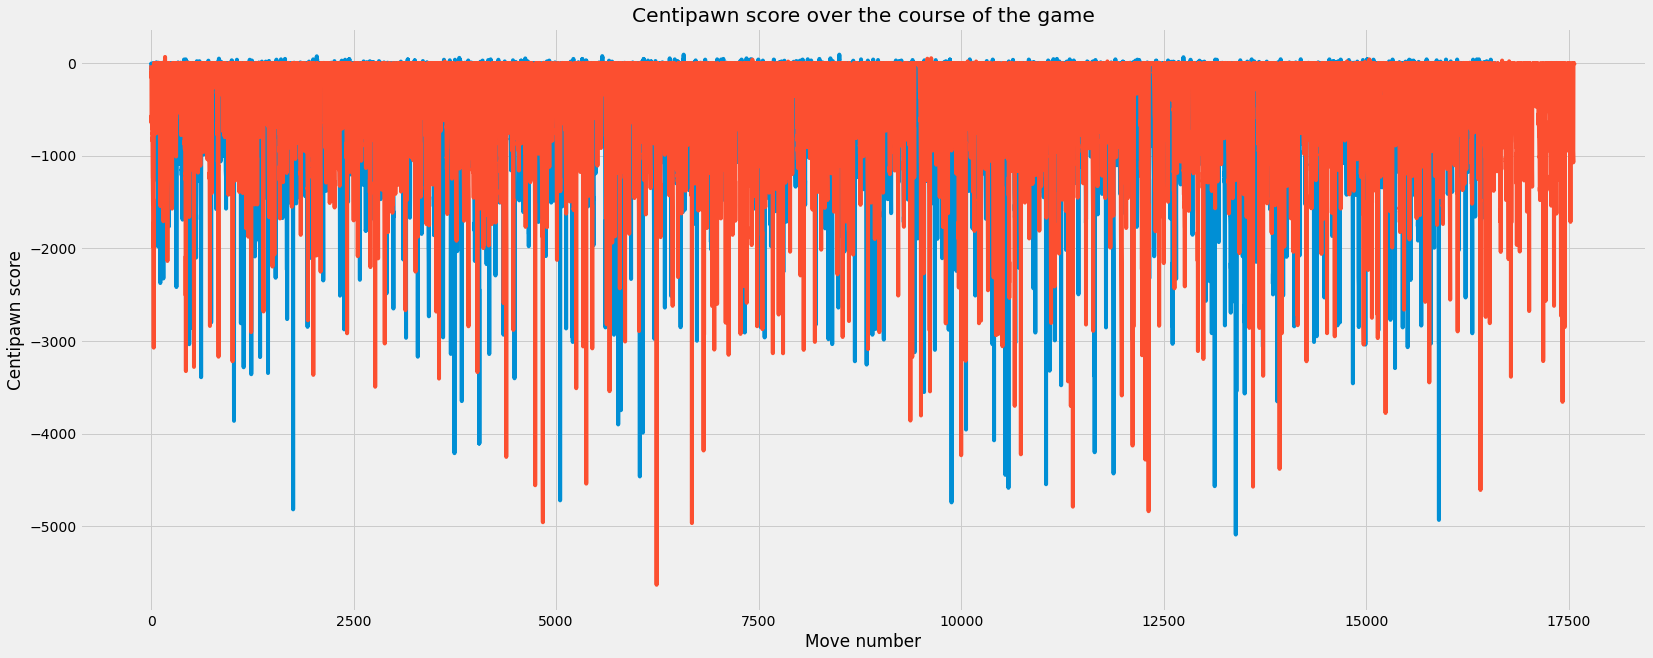

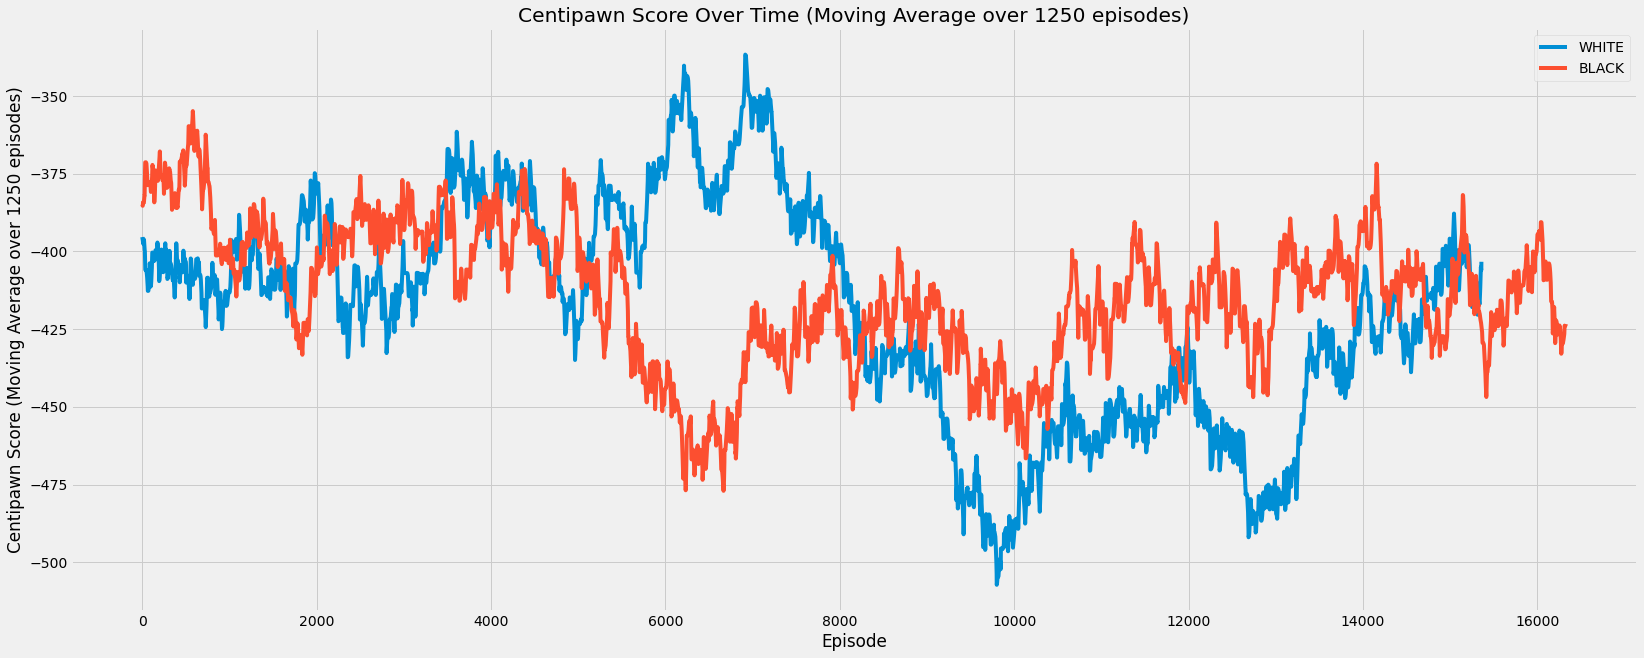

In [14]:
env = ChessEnvWrapper(gym.make('ChessAlphaZero-v0'))
states = env.observation_space.shape
actions = env.action_space.n
model = build_model(states, actions, initial_learning_rate = 0.1,
        decay_steps=10, decay_rate=0.9)

df = AGENT_EVALUATION(Stockfish_path, WHITE_PLAYER_POLICY, model, 
        n_evaluations=500, epsilon=1, epsilon_min=0.01, epsilon_decay=0.985,
        discount_factor = 0.99, avg_window_small=100, avg_window_big=1250)

### Visualize next moves after a set board state

This section constists of, after having trained the agent, and seing what Q-values the agent predicts for each of the possible moves to better visualize it's reasoning.

In [16]:
# Initialize the environment
env = gym.make('ChessAlphaZero-v0')
env.reset()

# Moves for Scholar's Mate
moves = ['e2e4', 'e7e5', 'f1c4', 'b8c6', 'd1h5', 'g8f6']

for move in moves:
    action = chess.Move.from_uci(move)
    encoded_action = env.encode(action)
    observation, _, _, _ = env.step(encoded_action)

# Define the mapping of square indices to labels
square_labels = [
    "a8", "b8", "c8", "d8", "e8", "f8", "g8", "h8",
    "a7", "b7", "c7", "d7", "e7", "f7", "g7", "h7",
    "a6", "b6", "c6", "d6", "e6", "f6", "g6", "h6",
    "a5", "b5", "c5", "d5", "e5", "f5", "g5", "h5",
    "a4", "b4", "c4", "d4", "e4", "f4", "g4", "h4",
    "a3", "b3", "c3", "d3", "e3", "f3", "g3", "h3",
    "a2", "b2", "c2", "d2", "e2", "f2", "g2", "h2",
    "a1", "b1", "c1", "d1", "e1", "f1", "g1", "h1"
]

# Display the board with square labels
board = env.render(mode='unicode')
board_rows = board.strip().split("\n")
board_with_labels = []

for i, row in enumerate(board_rows):
    board_with_labels.append(f"{8 - i} {row}")  # Add row number
board_with_labels.append("  a  b  c  d  e  f  g  h")  # Add column labels

print("\n".join(board_with_labels))

# Get all legal moves
legal_moves = [env.decode(i) for i in env.legal_actions]
#print("Legal moves:", legal_moves)

def WHITE_PLAYER_POLICY_mate(env, state, model, epsilon):
    legal_actions = list(map(env.encode, env.legal_moves))  # Convert legal moves to action indices
    max_q_value = 0  # Initialize max_q_value

    if np.random.rand() <= epsilon:
        action = np.random.choice(legal_actions)  # Explore legal action space
        q_values_of_actions = None  # No Q values when exploring randomly
    else:
        # Reshape the state to match the expected input shape
        reshaped_state = np.expand_dims(state, axis=0)
        q_values = model.predict(reshaped_state)  # Exploit learned values
        max_q_value = np.max(q_values[0]) 
        action = np.argmax(q_values[0])

        # Ensure chosen action is legal, fallback to random legal action if not
        if action not in legal_actions:
            action = np.random.choice(legal_actions) 
            
        # Get Q values for all legal actions and map them to the corresponding moves
        q_values_of_actions = {env.decode(legal_action): q_values[0][legal_action] for legal_action in legal_actions}

    return action, max_q_value, q_values_of_actions

# Use the environment and model
action, max_q_value, q_values_of_actions = WHITE_PLAYER_POLICY_mate(env, observation, model, epsilon= 0.1)
#print(q_values_of_actions)
print()

# Sort the Q values and corresponding moves from highest to lowest Q value
sorted_q_values = sorted(q_values_of_actions.items(), key=lambda item: item[1], reverse=True)

# Print the sorted Q values and moves
for move, q_value in sorted_q_values:
    print(f"Move: {move}, Q value: {q_value}")


8 ♜ ⭘ ♝ ♛ ♚ ♝ ⭘ ♜
7 ♟ ♟ ♟ ♟ ⭘ ♟ ♟ ♟
6 ⭘ ⭘ ♞ ⭘ ⭘ ♞ ⭘ ⭘
5 ⭘ ⭘ ⭘ ⭘ ♟ ⭘ ⭘ ♕
4 ⭘ ⭘ ♗ ⭘ ♙ ⭘ ⭘ ⭘
3 ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘ ⭘
2 ♙ ♙ ♙ ♙ ⭘ ♙ ♙ ♙
1 ♖ ♘ ♗ ⭘ ♔ ⭘ ♘ ♖
  a  b  c  d  e  f  g  h
Legal moves: [Move.from_uci('h5h7'), Move.from_uci('h5f7'), Move.from_uci('h5h6'), Move.from_uci('h5g6'), Move.from_uci('h5g5'), Move.from_uci('h5f5'), Move.from_uci('h5e5'), Move.from_uci('h5h4'), Move.from_uci('h5g4'), Move.from_uci('h5h3'), Move.from_uci('h5f3'), Move.from_uci('h5e2'), Move.from_uci('h5d1'), Move.from_uci('c4f7'), Move.from_uci('c4e6'), Move.from_uci('c4a6'), Move.from_uci('c4d5'), Move.from_uci('c4b5'), Move.from_uci('c4d3'), Move.from_uci('c4b3'), Move.from_uci('c4e2'), Move.from_uci('c4f1'), Move.from_uci('g1h3'), Move.from_uci('g1f3'), Move.from_uci('g1e2'), Move.from_uci('e1e2'), Move.from_uci('e1f1'), Move.from_uci('e1d1'), Move.from_uci('b1c3'), Move.from_uci('b1a3'), Move.from_uci('h2h3'), Move.from_uci('g2g3'), Move.from_uci('f2f3'), Move.from_uci('d2d3'), Move.from_uci('c2c3'), Move.from_uc